# Exploratory Data Analysis

In this notebook we'll do some exploratory data analysis over our dataset. However, since we don't have our features created yet, we cannot do much at this point. In addition, when we create them, we won't be able to extract many insights because of the nature of text-based features. For this reason, only a shallow analysis will be done at this point.

In [1]:
import pandas as pd
import numpy as np
from IPython.display import HTML
import seaborn as sns
import base64
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import re
from imblearn.over_sampling import SMOTE
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

C:\Users\Keletso\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\Keletso\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [8]:
df_train = pd.read_csv('C:/Users/Keletso/Documents/Research Paper Classification/0. Raw Data Set/train.csv')
df_test = pd.read_csv('C:/Users/Keletso/Documents/Research Paper Classification/0. Raw Data Set/test.csv')
#df_not_null = df[pd.notnull(df['combined'])]
#print(df_not_null.shape)

In [10]:
df_train.head(10)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0
5,6,On maximizing the fundamental frequency of the...,Let $\Omega \subset \mathbb{R}^n$ be a bound...,0,0,1,0,0,0
6,7,On the rotation period and shape of the hyperb...,We observed the newly discovered hyperbolic ...,0,1,0,0,0,0
7,8,Adverse effects of polymer coating on heat tra...,The ability of metallic nanoparticles to sup...,0,1,0,0,0,0
8,9,SPH calculations of Mars-scale collisions: the...,We model large-scale ($\approx$2000km) impac...,0,1,0,0,0,0
9,10,$\mathcal{R}_{0}$ fails to predict the outbrea...,Time varying susceptibility of host at indiv...,0,0,0,0,1,0


## Number of research papers in each fields

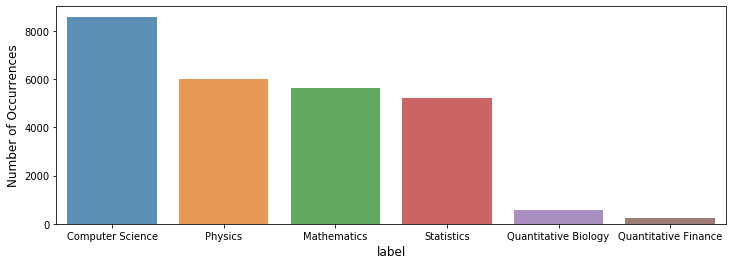

In [26]:
cnt_srs = df_train[['Computer Science','Physics','Mathematics','Statistics','Quantitative Biology','Quantitative Finance']].sum(axis=0)

plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('label', fontsize=12)
plt.show()

We have a large volume of research papers from the Computer Science field, and a very limited volume of articles in the fields of Quantitative Biology and Quantitative Finance. We might have to try synthetic oversampling for using smote to solve the imbalance. 

## Title and Abstract length by field

In [29]:
df_train['Title_length'] = df_train['TITLE'].str.len()
df_train['Abstract_length'] = df_train['ABSTRACT'].str.len()

C:\Users\Keletso\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


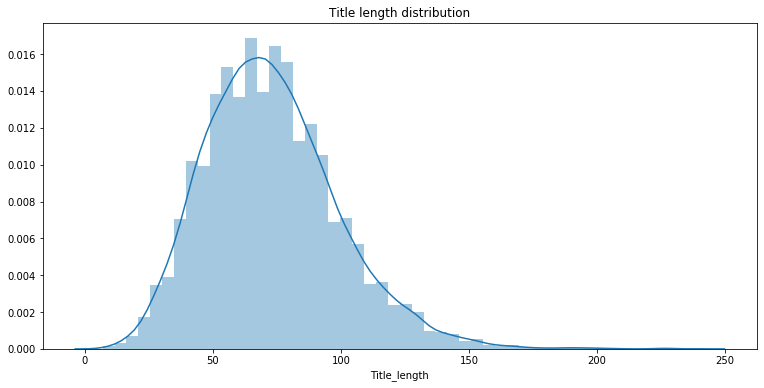

In [31]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_train['Title_length']).set_title('Title length distribution');

In [34]:
df_train['Title_length'].describe()

count    20972.000000
mean        72.897721
std         26.128903
min          7.000000
25%         54.000000
50%         71.000000
75%         88.000000
max        239.000000
Name: Title_length, dtype: float64

Lets remove the 95th percentile onwards to better understand the distribution

In [36]:
quantile_95 = df_train['Title_length'].quantile(0.95)
df_95 = df_train[df_train['Title_length'] < quantile_95]

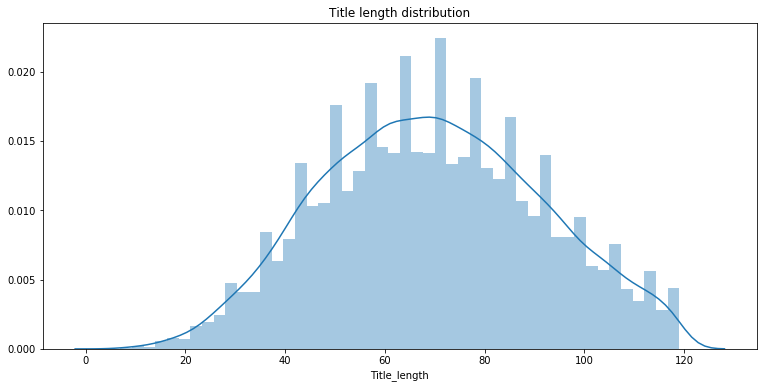

In [38]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_95['Title_length']).set_title('Title length distribution');

We can get the number of reseach papers with titles longer than 200 characters:

In [46]:
df_more200 = df_train[df_train['Title_length'] > 200]
len(df_more200)

12

Let's see one:

In [47]:
df_more200['TITLE'].iloc[1]

'A Galactic Cosmic Ray Electron Intensity Increase of a factor of up to 100 At Energies between 3 and 50 MeV in the Heliosheath between the Termination Shock and the Heliopause Due to Solar Modulation As Measured by Voyager 1'

Let's view title length by research field

In [66]:
def get_fields(row):
    dictionary={}   
    for c in df_train[['Computer Science','Physics','Mathematics','Statistics','Quantitative Biology','Quantitative Finance']].columns:
        if row[c]==1:      
            return c

In [74]:
field_names=pd.DataFrame(df_train.apply(get_fields, axis=1))

In [75]:
field_names['Title_length']=df_train['Title_length']

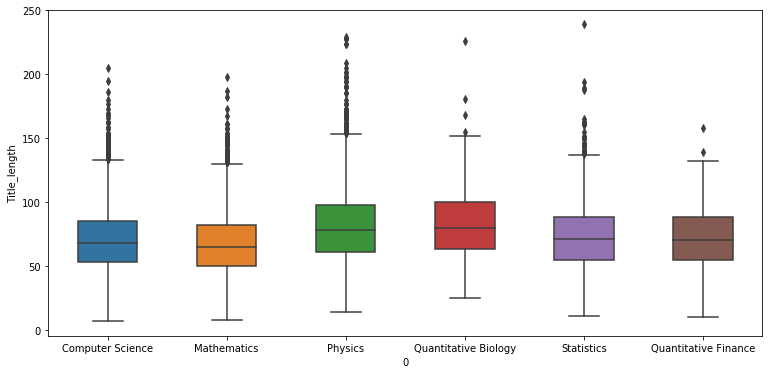

In [79]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=field_names, x=0, y='Title_length', width=.5);

Seems like Physics and Quantitative Biology have slightly higher length of text.

Let's perform a similar analysis for abstract

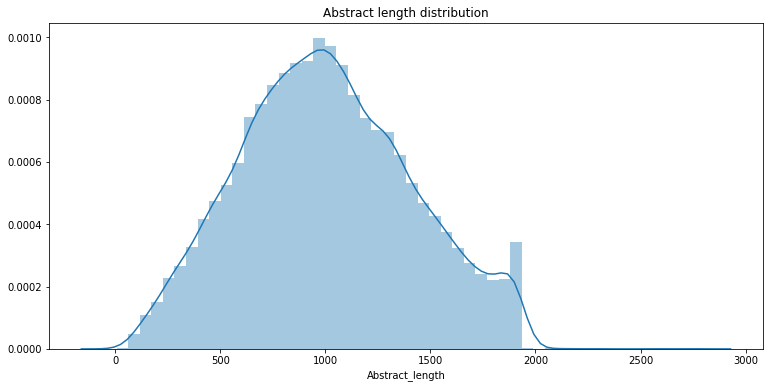

In [32]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_train['Abstract_length']).set_title('Abstract length distribution');

In [80]:
df_train['Abstract_length'].describe()

count    20972.000000
mean      1009.103376
std        408.641363
min          7.000000
25%        714.000000
50%        989.000000
75%       1290.000000
max       2761.000000
Name: Abstract_length, dtype: float64

removing the 95th percentile

In [81]:
quantile_abstract_95 = df_train['Abstract_length'].quantile(0.95)
df_abstract_95 = df_train[df_train['Abstract_length'] < quantile_abstract_95]

C:\Users\Keletso\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


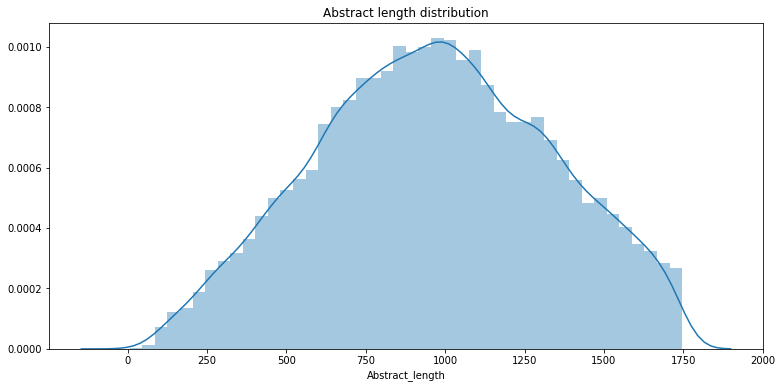

In [82]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_abstract_95['Abstract_length']).set_title('Abstract length distribution');

The number of reseach papers with abstracts longer than 2000 characters:

In [83]:
df_abstract_more2000 = df_train[df_train['Abstract_length'] > 2000]
len(df_abstract_more2000)

6

Example:

In [84]:
df_abstract_more2000['ABSTRACT'].iloc[1]

'  The context of this research is testing and building software systems and,\nspecifically, software language repositories (SLRs), i.e., repositories with\ncomponents for language processing (interpreters, translators, analyzers,\ntransformers, pretty printers, etc.). SLRs are typically set up for developing\nand using metaprogramming systems, language workbenches, language definition\nframeworks, executable semantic frameworks, and modeling frameworks. This work\nis an inquiry into testing and building SLRs in a manner that the repository is\nseen as a collection of language-typed artifacts being related by the\napplications of language-typed functions or relations which serve language\nprocessing. The notion of language is used in a broad sense to include text-,\ntree-, graph-based languages as well as representations based on interchange\nformats and also proprietary formats for serialization. The overall approach\nunderlying this research is one of language design driven by a comp

Let's view abstract length by research field

In [85]:
field_names['Abstract_length']=df_train['Abstract_length']

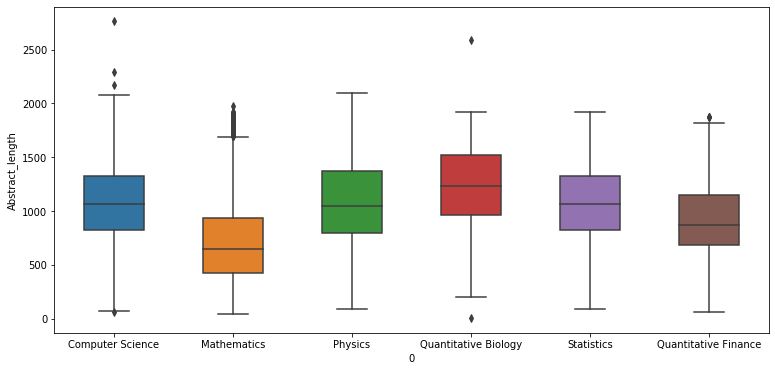

In [86]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=field_names, x=0, y='Abstract_length', width=.5);

Seems like Mathematics has a lower number of text than the rest, while Quantitative Biology has slightly higher length of text.

We can see that, although the length distribution is different for every research field, the difference is not too big. If we had way too different lengths between research fields we would have a problem since the feature creation process may take into account counts of words. However, when creating the features with TF-IDF scoring, we will normalize the features just to avoid this.

At this point, we cannot do further Exploratory Data Analysis. We'll turn onto the **Feature Engineering** section.

We'll save the dataset:

In [88]:
import pickle
with open('research_dataset.pickle', 'wb') as output:
    pickle.dump(df_train, output)